Копия блокнота с оптимизированной моделью

# Задание 6, 7

## Условие

- Пусть в портфеле находятся все кредиты, выданные 01.01.2017 или позже, притом без учета признака дефолта — для целей этого упражнения мы предполагаем, что они все активны в настоящее время. Предположим, что LGD=100%, а текущая задолженность по каждому кредиту равна полю funded_amnt. При помощи обеих моделей рассчитайте ожидаемые потери (математическое ожидание) и неожидаемые потери (VaR на уровне 99.9%). Рассчитайте необходимый капитал как разность этих двух величин. Не забудьте доверительные интервалы.
    - В предположении независимости дефолтов по отдельным кредитам.
    - С учётом корреляций между дефолтами в 6%.

- Принимая LGD=100%, рассчитайте для обеих моделей по обучающей выборке порог отсечения, максимизирующий ожидаемую прибыль от кредитования. Постройте графики зависимости ожидаемой прибыли от порога отсечения (для двух моделей в одних осях). Не забудьте доверительные интервалы.

## Решение

**Формулы для расчетов**

Фактические потери
$$loss = \sum_i funded\_amnt_i \cdot \mathbf{1}\{target_i = 1\} \cdot \mathbf{1}\{score_i < thr\}$$

Ожидаемая прибыль от кредитования 
$$profit = prc\_profit - loss$$
$$prc\_profit = \sum_i (installment_i \cdot term_i - funded\_amnt_i) \cdot \mathbf{1}\{target_i = 0\} \cdot \mathbf{1}\{score_i < thr\}$$

Максимально возможная прибыль $$max\_profit = \sum_i (installment_i \cdot term_i - funded\_amnt_i) \cdot \mathbf{1}\{target_i = 0\}$$

Максимально возможный убыток $$max\_loss = \sum_i funded\_amnt_i \cdot \mathbf{1}\{target_i = 1\}$$

Неожидаемые потери
$$UL = VaR_{99.9} \sum_i \cfrac{funded\_amnt_i \cdot \mathbf{1}\{score_i > rand_j\}}{funded\_amnt_i}$$

Ожидаемые потери 
$$EL = \sum_i \cfrac{funded\_amnt_i \cdot score_i}{funded\_amnt_i}$$

Необходимый капитал
$$capital = UL - EL$$

Предлагается проходиться случайными батчами по клиентам и получать ожидаемые и неожидаемые потери по каждой симуляции. По этим распределениям можно построить доверительные интервалы.
Итоговое распределение потерь можно получить, объеденив потери по всем симуляциям.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score
from tqdm.auto import tqdm
import catboost

In [2]:
scores = pd.read_parquet(f"/home/asciishell/s3/jupyter.asciishell.ru/data_oot.parquet")  # .head(10_000)
clf = catboost.CatBoostClassifier()
clf.load_model('./catboost.cb')
scores['score'] = clf.predict_proba(scores[clf.feature_names_])[:, 1]
scores.shape

(938821, 67)

In [3]:
scores.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_title,emp_length,home_ownership,annual_inc,...,sec_app_earliest_cr_line,sec_app_mort_acc,sec_app_open_acc,sec_app_num_rev_accts,disbursement_method,target,debt_load,log_annual_inc,fraq_annual_inc,score
0,5000.0,5000.0,5000.0,36.0,20.39,186.82,general manager,8,RENT,50000.0,...,NaN,NaN,NaN,NaN,Cash,-1,0.044837,10.819798,NaN,0.228441
1,15000.0,15000.0,15000.0,36.0,9.92,483.45,__other__,2,OWN,196000.0,...,NaN,NaN,NaN,NaN,Cash,-1,0.029599,12.185875,NaN,0.118867
2,11200.0,11200.0,11200.0,60.0,30.79,367.82,__other__,0,RENT,44000.0,...,4776.0,1.0,14.0,8.0,Cash,-1,0.100315,10.691968,0.54321,0.266431
3,25000.0,25000.0,25000.0,60.0,21.85,688.35,__other__,10,MORTGAGE,65000.0,...,NaN,NaN,NaN,NaN,Cash,-1,0.127080,11.082158,NaN,0.410733
4,3000.0,3000.0,3000.0,36.0,7.34,93.10,__other__,9,RENT,52000.0,...,NaN,NaN,NaN,NaN,Cash,0,0.021485,10.859018,NaN,0.043532


## Максимизация ожидаемой прибыли

In [4]:
sc_range = sorted(set(np.percentile(scores["score"], np.arange(50))) | set(np.linspace(0, 1, 50)))
scores_target = scores[scores["target"] != -1]
max_profit = scores_target[scores_target["target"] == 0]
max_profit = (max_profit["installment"] * max_profit["term"] - max_profit["funded_amnt"]).sum()
profits = []
for i in tqdm(sc_range):
    loss = scores_target[(scores_target["score"] < i) & (scores_target["target"] == 1)]["funded_amnt"].sum()
    profit = scores_target[(scores_target["score"] < i) & (scores_target["target"] == 0)]
    profit = (profit["installment"] * profit["term"] - profit["funded_amnt"]).sum()
    profits.append((profit - loss) / max_profit)

  0%|          | 0/100 [00:00<?, ?it/s]

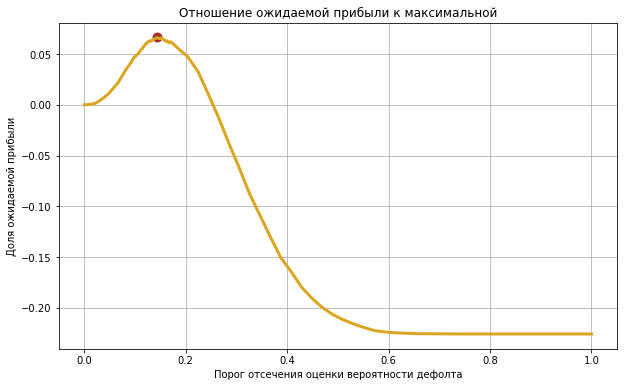

In [5]:
plt.figure(figsize=(10, 6), facecolor="w")
plt.plot(sc_range, profits, color="goldenrod", linewidth=3)
plt.scatter(sc_range[np.argmax(profits)], max(profits), s=80, c="brown")
plt.title("Отношение ожидаемой прибыли к максимальной")
plt.xlabel("Порог отсечения оценки вероятности дефолта")
plt.ylabel("Доля ожидаемой прибыли")
plt.grid()
plt.show()

In [6]:
best_thr = sc_range[np.argmax(profits)]
best_thr

0.14358894955044166

In [7]:
real_loss = (
    scores[(scores["score"] < best_thr) & (scores["target"] == 1)]["funded_amnt"].sum()
    / scores[scores["target"] == 1]["funded_amnt"].sum()
)
real_loss

0.15292020844339282

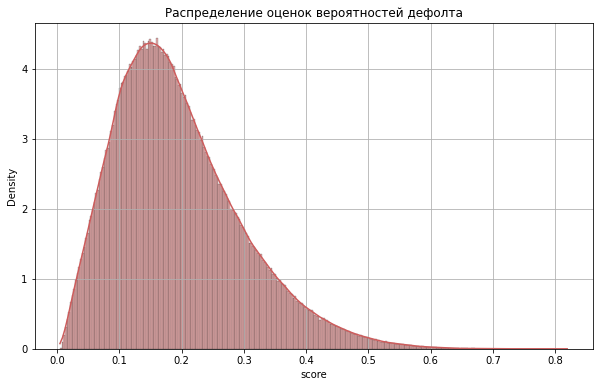

In [8]:
plt.figure(figsize=(10, 6), facecolor="w")
sns.histplot(scores["score"], stat="density", kde=True, color="indianred")
plt.title("Распределение оценок вероятностей дефолта")
plt.grid()
plt.show()

## Расчет капитала

In [9]:
exp = {"ul": [], "el": [], "var": [], "capital": []}
exp_corr = {"ul": [], "el": [], "var": [], "capital": []}
for i in tqdm(range(100)):
    scr = scores.sample(1000, random_state=i)

    # капитал
    el = (scr["funded_amnt"] * scr["score"]).sum() / scr["funded_amnt"].sum()
    rnd = np.random.RandomState(i)
    rnd_vec = rnd.uniform(size=(scr.shape[0], 1000)).astype(np.float32)
    ul = ((scr["score"].values[..., None] - rnd_vec > 0) * scr["funded_amnt"].values[..., None]).sum(axis=0) / scr[
        "funded_amnt"
    ].sum()
    exp["ul"].extend(rnd.choice(ul, 50))
    exp["var"].append(np.percentile(ul, q=99.9))
    exp["el"].append(el)
    exp["capital"].append(np.percentile(ul, q=99.9) - el)

    corr_matrix = np.ones((scr.shape[0], scr.shape[0])) * 0.06
    np.fill_diagonal(corr_matrix, 1)
    corr_matrix = np.linalg.cholesky(corr_matrix)
    rnd_vec = corr_matrix @ rnd_vec
    rnd_vec = ((rnd_vec.T - np.min(rnd_vec, axis=1)) / (np.max(rnd_vec, axis=1) - np.min(rnd_vec, axis=1))).T
    ul = ((scr["score"].values[..., None] - rnd_vec > 0) * scr["funded_amnt"].values[..., None]).sum(axis=0) / scr[
        "funded_amnt"
    ].sum()
    exp_corr["ul"].extend(rnd.choice(ul, 50))
    exp_corr["var"].append(np.percentile(ul, q=99.9))
    exp_corr["el"].append(el)
    exp_corr["capital"].append(np.percentile(ul, q=99.9) - el)

  0%|          | 0/100 [00:00<?, ?it/s]

Форма колокола говорит о том, что дефолты независимые и с одинаковой вероятностью реализуются события разной убыточности

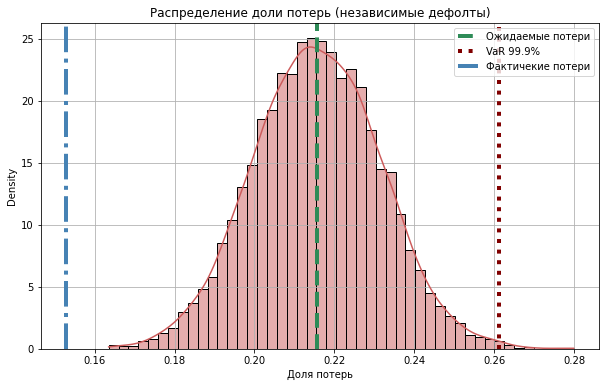

In [10]:
plt.figure(figsize=(10, 6), facecolor="w")
sns.histplot(exp["ul"], stat="density", kde=True, color="indianred")
plt.axvline(np.mean(exp["el"]), color="seagreen", linestyle="--", linewidth=4, label="Ожидаемые потери")
plt.axvline(np.mean(exp["var"]), color="maroon", linestyle=":", linewidth=4, label="VaR 99.9%")
plt.axvline(real_loss, color="steelblue", linestyle="-.", linewidth=4, label="Фактичекие потери")
plt.title("Распределение доли потерь (независимые дефолты)")
plt.xlabel("Доля потерь")
plt.legend()
plt.grid()
plt.show()

Распределение имеет тяжелый хвост справа - это говорит о том, что для скоррелированных дефолтов чаще реализуются более негативные сценарии. При этом разброс потерь больше

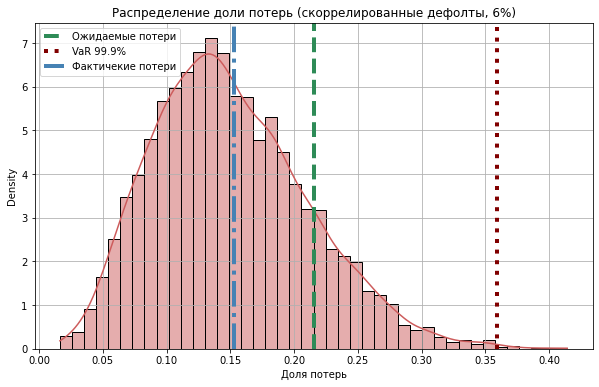

In [11]:
plt.figure(figsize=(10, 6), facecolor="w")
sns.histplot(exp_corr["ul"], stat="density", kde=True, color="indianred")
plt.axvline(np.mean(exp_corr["el"]), color="seagreen", linestyle="--", linewidth=4, label="Ожидаемые потери")
plt.axvline(np.mean(exp_corr["var"]), color="maroon", linestyle=":", linewidth=4, label="VaR 99.9%")
plt.axvline(real_loss, color="steelblue", linestyle="-.", linewidth=4, label="Фактичекие потери")
plt.title("Распределение доли потерь (скоррелированные дефолты, 6%)")
plt.xlabel("Доля потерь")
plt.legend()
plt.grid()
plt.show()

## Ожидаемая прибыль

In [12]:
profits = []
metrics = []
scores_target = scores[scores["target"] != -1]
for i in tqdm(range(1000)):
    scr = scores_target.sample(30000, random_state=i)

    # ожидаемая прибыль
    max_profit = scr[scr["target"] == 0]
    max_profit = (max_profit["installment"] * max_profit["term"] - max_profit["funded_amnt"]).sum()

    loss = scr[(scr["score"] < best_thr) & (scr["target"] == 1)]["funded_amnt"].sum()
    profit = scr[(scr["score"] < best_thr) & (scr["target"] == 0)]
    profit = (profit["installment"] * profit["term"] - profit["funded_amnt"]).sum()
    profits.append((profit - loss) / max_profit)

    metrics.append(roc_auc_score(scr["target"], scr["score"]) * 2 - 1)

  0%|          | 0/1000 [00:00<?, ?it/s]

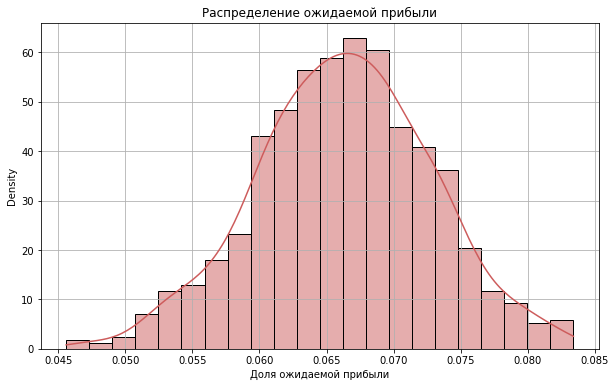

In [13]:
plt.figure(figsize=(10, 6), facecolor="w")
sns.histplot(profits, stat="density", kde=True, color="indianred")
plt.title("Распределение ожидаемой прибыли")
plt.xlabel("Доля ожидаемой прибыли")
plt.grid()
plt.show()

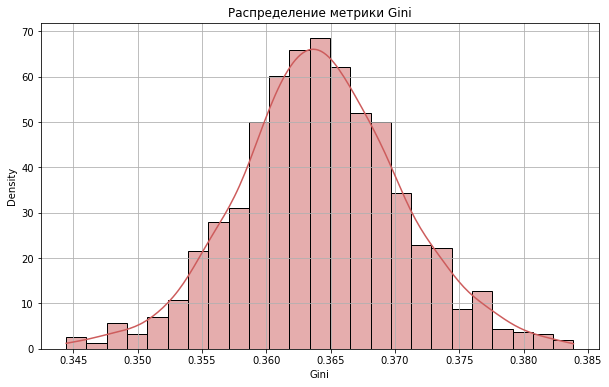

In [14]:
plt.figure(figsize=(10, 6), facecolor="w")
sns.histplot(metrics, stat="density", kde=True, color="indianred")
plt.title("Распределение метрики Gini")
plt.xlabel("Gini")
plt.grid()
plt.show()

## Итоговый результат

In [15]:
pd.DataFrame(
    [
        [np.mean(exp["capital"]), np.percentile(exp["capital"], q=0.5), np.percentile(exp["capital"], q=99.5)],
        [
            np.mean(exp_corr["capital"]),
            np.percentile(exp_corr["capital"], q=0.5),
            np.percentile(exp_corr["capital"], q=99.5),
        ],
        [np.mean(metrics), np.percentile(metrics, q=0.5), np.percentile(metrics, q=99.5)],
        [np.mean(profits), np.percentile(profits, q=0.5), np.percentile(profits, q=99.5)],
    ],
    columns=["mean", "LB 99", "UB 99"],
    index=[
        "Капитал (независимые дефолты)",
        "Капитал (коррелированные дефолты)",
        "Коэффициент Джини",
        "Ожидаемая прибыль (доля)",
    ],
).round(4)

,mean,LB 99,UB 99
Капитал (независимые дефолты),0.0456,0.0386,0.0541
Капитал (коррелированные дефолты),0.1436,0.1092,0.1967
Коэффициент Джини,0.3642,0.3476,0.3815
Ожидаемая прибыль (доля),0.0663,0.0498,0.0821
